# Problema de Negocio 

Airbnb opera no mercado online de hospedagem, principalmente com casas de família para aluguel de temporada e atividade de turismo. No memento se observou a necessidade de prever o primeiro destino que um novo usuário vai escolher para fazer sua reserva de hospedagem.

**Causa raiz**: Por se tratar de um modelo de marketplace, onde visa conectar pessoas que oferecem um serviço, com pessoas que estão em busca dos mesmo, a necessidade vem de prever o destino para melhor aplicar a campanha de marketing. Buscando diminuir o CAC. 

## Planejamento da Entrega 

1. Resposta
- prever o destino do primeiro agendamento de hospedagem do usuário. 

2. Formato de entrega
- Json com os dados do cliente e a classificação do destino. 

3. Local de entrega 
- Api 

## Planejamento do Processo 

1. Extração e carregamento dos dados. 
2. Análise descritiva e  do dataset. 
3. Validação e tratamento de dados faltantes 
4. Feature engineering
5. Balanceamento dos dados. 
6. EAD.
7. Modelagem de dados
8. Seleção dos atributos relevantes 
9. Modelagem de algoritmo classificador e fine tunning
10. Criação Class Pipeline de dados e API Handler 
11. Deploy em produção 

## Planejamento de Entrada

1. Fonte dos dados 
- **kaggle** https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data
    
2. Ferramentas 
- Python 3 
- Flask 
- Sklearn 
- Jupyter Notebook 
- Heroku 

# 0.0 Import 

In [134]:
import pandas as pd 
import matplotlib.pyplot

import sklearn.preprocessing as pp
from sklearn.model_selection import train_test_split
from keras import models as ml
from keras import layers as l
from sklearn import metrics
from scikitplot import metrics as mt
import os
    

## 0.1 Helper Functions 

In [64]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## 0.2 Carregamento de dados 

In [2]:
df_user_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/train_users_2.csv')
# df_sessions_raw = pd.read_csv('/home/giovane/Documentos/repo/airbnb_previsao_agendamento/data/raw/sessions.csv')

# 1.0 Análise Descritiva 

In [3]:
# verificando o a dimensao dos dados (Linhas e colunas)
# Tipo dos atributos 
df_user_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

## 1.2 Dados Faltantes ( NA ) 

In [4]:
df_user_raw.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

O dataset possui 3 colunas onde apresentam dados faltantes( NA ) 
- date_first_booking 
- age 
- first_affiliate_tracked 

## 1.3 Preenchendo NA

Como parte do primeiro ciclo de desenvolvimento focando na entrega de valor, foi adotado a exlusão das linhas com NA tendo em vista a grande redução de registros do dataset.

In [5]:
df_user_raw.dropna(inplace=True)

In [6]:
df_user_raw.shape

(68171, 16)

## 1.1 Alterando Data Type

In [7]:
df_user_raw.sample(1).T

,137324
id,jqygii7o35
date_account_created,2014-01-02
timestamp_first_active,20140102084807
date_first_booking,2014-01-03
gender,-unknown-
age,105.0
signup_method,basic
signup_flow,24
language,en
affiliate_channel,direct


In [8]:
df_user_raw['date_account_created'] = pd.to_datetime(df_user_raw['date_account_created'])  
df_user_raw['timestamp_first_active'] = pd.to_datetime(df_user_raw['timestamp_first_active'], format='%Y%m%d%H%M%S') 
df_user_raw['date_first_booking'] = pd.to_datetime(df_user_raw['date_first_booking'])  
df_user_raw['age'] = df_user_raw['age'].astype(int)

In [9]:
df_user_raw.sample(1).T

,57662
id,kk4xvlqhad
date_account_created,2013-01-26 00:00:00
timestamp_first_active,2013-01-26 21:25:23
date_first_booking,2013-09-05 00:00:00
gender,FEMALE
age,33
signup_method,basic
signup_flow,0
language,en
affiliate_channel,direct


# 2.0 Filtragem de Atributos  

In [114]:
df2 = df_user_raw.copy()

In [115]:
#removendo atributos que nao existem no momento da predicao 
df2.drop(['id', 'timestamp_first_active', 'date_first_booking', 'date_account_created'], axis=1, inplace=True)

# 3.0 Modelagem de Dados 

In [116]:
df3 = df2.copy()

## 3.1 Encoding 

In [117]:
df3.head(1).T

,2
gender,FEMALE
age,56
signup_method,basic
signup_flow,3
language,en
affiliate_channel,direct
affiliate_provider,direct
first_affiliate_tracked,untracked
signup_app,Web
first_device_type,Windows Desktop


In [118]:
df3_dommies = pd.get_dummies(df3.drop('country_destination', axis=1))
df3 = pd.concat([df3_dommies, df3['country_destination']], axis=1)

# 4.0 Modelagem Machine Learning - Neural Network 

In [119]:
df4 = df3.copy()

## 4.1 Separar Dados Teste e Validação  

In [120]:
x = df4.drop('country_destination', axis=1)
y = df4['country_destination'].copy()

In [121]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [122]:
encoder = pp.OneHotEncoder()
y_train = encoder.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [123]:
# definicao do modelo
model = ml.Sequential()
model.add(l.Dense(128, input_dim=x_train.shape[1], activation="relu"))
model.add(l.Dense(11, activation="softmax"))

# compilando modelo 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

# treinamento 
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
1705/1705 [==============================] - 2s 955us/step - loss: 1.3504 - accuracy: 0.7025
Epoch 2/100
1705/1705 [==============================] - 1s 791us/step - loss: 1.2671 - accuracy: 0.7066
Epoch 3/100
1705/1705 [==============================] - 1s 789us/step - loss: 1.2317 - accuracy: 0.7068
Epoch 4/100
1705/1705 [==============================] - 1s 768us/step - loss: 1.2131 - accuracy: 0.7068
Epoch 5/100
1705/1705 [==============================] - 1s 750us/step - loss: 1.1852 - accuracy: 0.7070
Epoch 6/100
1705/1705 [==============================] - 1s 729us/step - loss: 1.1710 - accuracy: 0.7070
Epoch 7/100
1705/1705 [==============================] - 1s 728us/step - loss: 1.1611 - accuracy: 0.7073
Epoch 8/100
1705/1705 [==============================] - 1s 776us/step - loss: 1.1472 - accuracy: 0.7072
Epoch 9/100
1705/1705 [==============================] - 1s 784us/step - loss: 1.1423 - accuracy: 0.7075
Epoch 10/100
1705/1705 [==============================]

1705/1705 [==============================] - 2s 967us/step - loss: 1.1040 - accuracy: 0.7100
Epoch 79/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1037 - accuracy: 0.7103
Epoch 80/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1029 - accuracy: 0.7102
Epoch 81/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1023 - accuracy: 0.7104
Epoch 82/100
1705/1705 [==============================] - 2s 1ms/step - loss: 1.1026 - accuracy: 0.7103
Epoch 83/100
1705/1705 [==============================] - 2s 981us/step - loss: 1.1023 - accuracy: 0.7103
Epoch 84/100
1705/1705 [==============================] - 2s 960us/step - loss: 1.1017 - accuracy: 0.7105
Epoch 85/100
1705/1705 [==============================] - 2s 924us/step - loss: 1.1013 - accuracy: 0.7107
Epoch 86/100
1705/1705 [==============================] - 2s 988us/step - loss: 1.1018 - accuracy: 0.7104
Epoch 87/100
1705/1705 [==============================] - 2s 948us/

# 5.0 Performance do Modelo  

In [131]:
# predicao 
pred = model.predict(x_test)

# invertendo o encoder 
yhat_nn = encoder.inverse_transform(pred)

y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1,-1)[0]

In [132]:
# acuracia 
metrics.accuracy_score(y_test_nn, yhat_nn)

0.7101576824349102

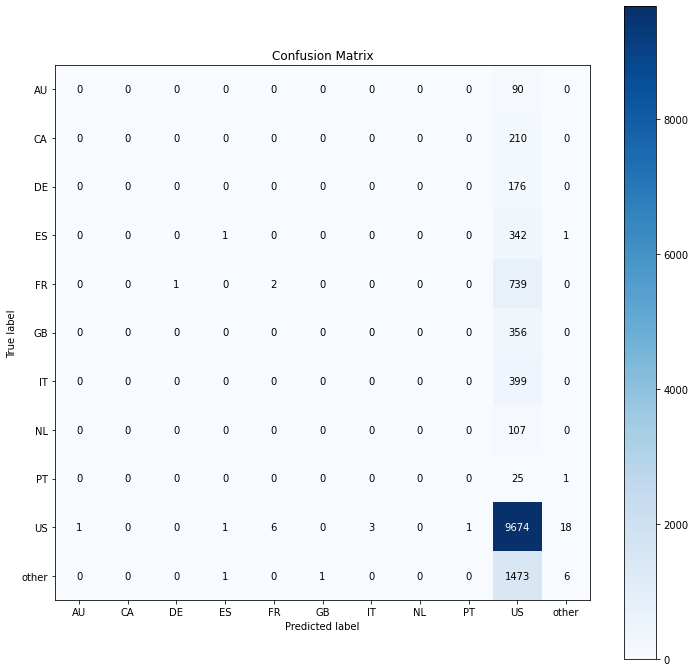

In [139]:
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12));

O modelo acabou sendo inviesado, pelo fato do dataset estar desbalanceado. Podemos ver também que a acuracia de acimade 70%, as mesma também segue sendo inviesada pelo grande número de registro com US.